In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import gc

In [3]:
def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        return 0
    elif file_name.startswith("task_motor"):
        return 1
    elif file_name.startswith("task_story"):
        return 2
    elif file_name.startswith("task_working"):
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_data_list = []
labels = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_data_list.append(data)
        labels.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_train_data_array = np.stack(meg_data_list, axis=0)
labels_train_array = np.array(labels)

In [ ]:
print(meg_train_data_array.shape)
print(labels_train_array.shape)

(32, 248, 35624)
(32,)


(8, 248, 35624)
(8, 248, 35624)
(8, 248, 35624)
(8, 248, 35624)


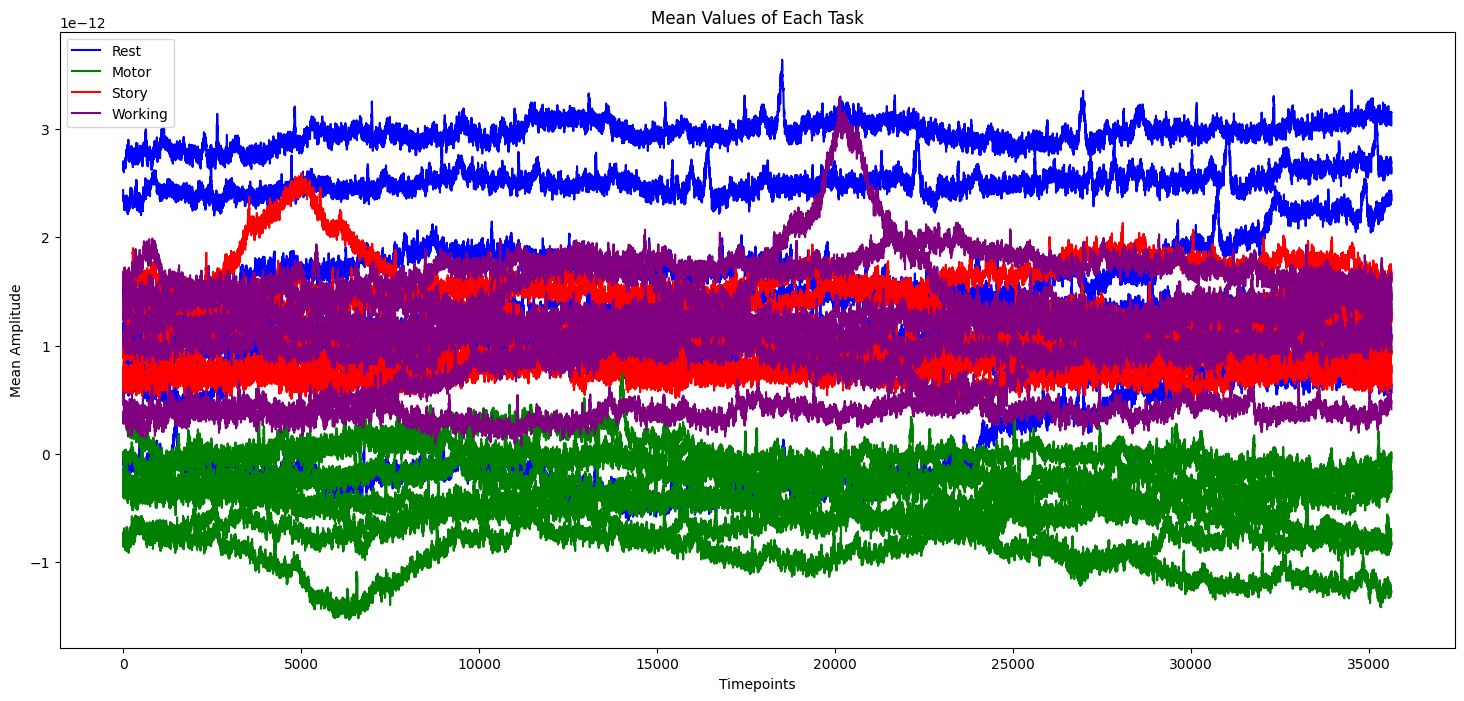

In [ ]:
#############################################################################
############################## WITHOUT SCALING ##############################
#############################################################################

# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = meg_train_data_array[labels_train_array == 0]
motor_class = meg_train_data_array[labels_train_array == 1]
story_class = meg_train_data_array[labels_train_array == 2]
working_class = meg_train_data_array[labels_train_array == 3]

print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)


# AVERAGE ALL SENSORSOF EACH OBSERVATION

mean_rest_class = np.mean(rest_class, axis=1)
mean_motor_class = np.mean(motor_class, axis=1)
mean_story_class = np.mean(story_class, axis=1)
mean_working_class = np.mean(working_class, axis=1)

import matplotlib.pyplot as plt

def plot_task_means(mean_arrays, task_labels, colors):
    plt.figure(figsize=(18, 8))

    # Plot an empty line for each task to create the legend
    for label, color in zip(task_labels, colors):
        plt.plot([], [], label=label, color=color)

    # Plot the actual data
    for mean_array, color in zip(mean_arrays, colors):
        for line in mean_array:
            plt.plot(line, color=color, alpha=1)

    plt.title("Mean Values of Each Task")
    plt.xlabel("Timepoints")
    plt.ylabel("Mean Amplitude")
    plt.legend()
    plt.show()

# Example usage remains the same
mean_arrays = [mean_rest_class, mean_motor_class, mean_story_class, mean_working_class]
task_labels = ["Rest", "Motor", "Story", "Working"]
colors = ["blue", "green", "red", "purple"]

plot_task_means(mean_arrays, task_labels, colors)

del mean_rest_class, mean_motor_class, mean_story_class, mean_working_class, mean_arrays, task_labels, colors, rest_class, motor_class, story_class, working_class

In [7]:
from sklearn.preprocessing import StandardScaler

def apply_scaling_z_score(data):
  scaler = StandardScaler()

  data_reshaped = data.reshape(-1, data.shape[1]*data.shape[2])
  scaler.partial_fit(data_reshaped)

  data_scaled = np.zeros_like(data)
  for i in range(data.shape[0]):
      sample = data[i].reshape(1, -1)  # Reshape each sample to 2D
      scaled_sample = scaler.transform(sample)  # Scale the sample
      data_scaled[i] = scaled_sample.reshape(data.shape[1], data.shape[2])

  return data_scaled

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)
  del array
  gc.collect()
  return array_filtered


def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp



In [4]:
meg_train_data_array.shape

(32, 248, 35624)

In [ ]:
from PIL import Image
from io import BytesIO

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_z_score = apply_scaling_z_score(meg_train_data_array)
array_filtered = apply_lowpass(array_scaled_z_score)
del array_scaled_z_score
array_doensampled = apply_downsampling(array_filtered)
del array_filtered

# Function to convert plot to image array
def plot_to_image_array(angle, radius):
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))
    ax.plot(angle, radius, color='blue')
    ax.fill(angle, radius, 'blue', alpha=1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)  # Disable the grid
    ax.spines['polar'].set_visible(False)

    # Save to buffer
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # Close the figure
    buf.seek(0)  # Rewind the buffer
    return np.array(Image.open(buf))

# Assuming meg_data is your data array
# Loop through each observation
images = []
for i in range(array_doensampled.shape[0]):
    observation = array_doensampled[i]  # Shape: (248, 35000)
    mean_signals = np.mean(observation, axis=1)  # Shape: (248,)

    radius = mean_signals
    angle = np.linspace(0, 2*np.pi, len(radius))

    image_array = plot_to_image_array(angle, radius)
    images.append(image_array)

# Now images[] contains image arrays for all observations


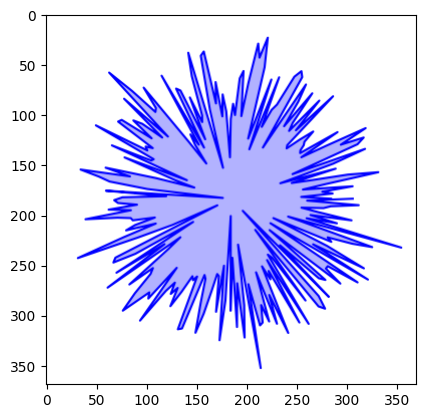

In [ ]:
plt.imshow(images[0])

(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)


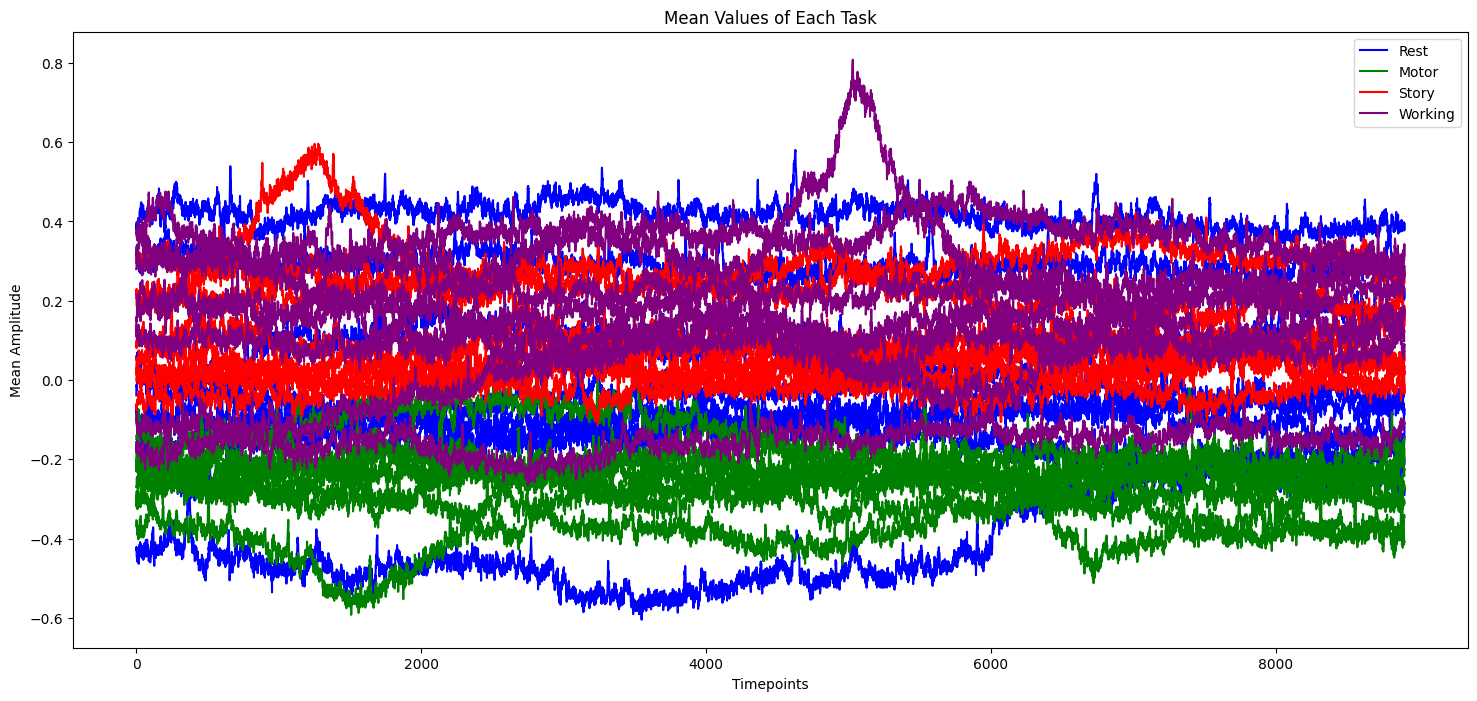

In [8]:
#############################################################################
############################## Z SCORE SCALING ##############################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_z_score = apply_scaling_z_score(meg_train_data_array)
array_filtered = apply_lowpass(array_scaled_z_score)
del array_scaled_z_score
array_doensampled = apply_downsampling(array_filtered)
del array_filtered


# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_doensampled[labels_train_array == 0]
motor_class = array_doensampled[labels_train_array == 1]
story_class = array_doensampled[labels_train_array == 2]
working_class = array_doensampled[labels_train_array == 3]

print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)



# AVERAGE ALL SENSORSOF EACH OBSERVATION

mean_rest_class = np.mean(rest_class, axis=1)
mean_motor_class = np.mean(motor_class, axis=1)
mean_story_class = np.mean(story_class, axis=1)
mean_working_class = np.mean(working_class, axis=1)

del rest_class, motor_class, story_class, working_class


def plot_task_means(mean_arrays, task_labels, colors):
    plt.figure(figsize=(18, 8))

    # Plot an empty line for each task to create the legend
    for label, color in zip(task_labels, colors):
        plt.plot([], [], label=label, color=color)

    # Plot the actual data
    for mean_array, color in zip(mean_arrays, colors):
        for line in mean_array:
            plt.plot(line, color=color, alpha=1)

    plt.title("Mean Values of Each Task")
    plt.xlabel("Timepoints")
    plt.ylabel("Mean Amplitude")
    plt.legend()
    plt.show()

# Example usage remains the same
mean_arrays = [mean_rest_class, mean_motor_class, mean_story_class, mean_working_class]
task_labels = ["Rest", "Motor", "Story", "Working"]
colors = ["blue", "green", "red", "purple"]

plot_task_means(mean_arrays, task_labels, colors)


del mean_rest_class, mean_motor_class, mean_story_class, mean_working_class, mean_arrays, task_labels, colors


In [ ]:
# per file
def min_max_scaling_per_file(data):
    # Initialize an empty array with the same shape as the input data
    scaled_data = np.zeros_like(data)

    # Iterate over each file
    for file_index in range(data.shape[0]):
        file_data = data[file_index, :, :]

        # Compute the min and max for this file
        min_val = np.min(file_data)
        max_val = np.max(file_data)

        # Apply Min-Max scaling for this file
        scaled_data[file_index, :, :] = (file_data - min_val) / (max_val - min_val) if max_val != min_val else file_data

    return scaled_data

# per sensor
def min_max_scaling_per_sensor(data):
    # Initialize an empty array with the same shape as the input data
    scaled_data = np.zeros_like(data)

    # Iterate over each sensor
    for sensor in range(data.shape[1]):
        # Flatten the data for this sensor across all files and timepoints
        sensor_data = data[:, sensor, :].flatten()

        # Compute the min and max for this sensor
        min_val = np.min(sensor_data)
        max_val = np.max(sensor_data)

        # Apply Min-Max scaling for this sensor
        scaled_data[:, sensor, :] = (data[:, sensor, :] - min_val) / (max_val - min_val)

    return scaled_data



(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)


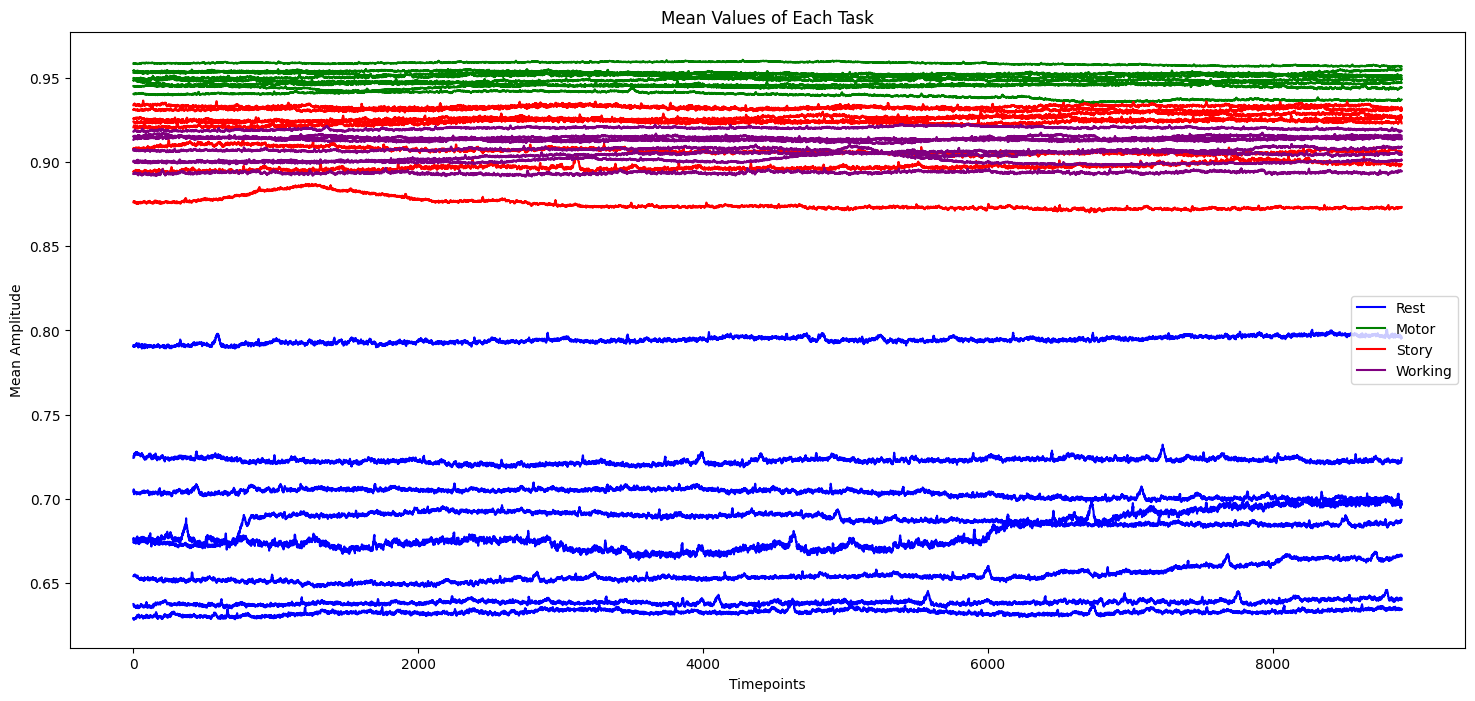

In [ ]:
#############################################################################
############################## MIN-MAX SCALING ##############################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_min_max = min_max_scaling_per_file(meg_train_data_array)
array_filtered = apply_lowpass(array_scaled_min_max)
del array_scaled_min_max
array_doensampled = apply_downsampling(array_filtered)
del array_filtered

# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_doensampled[labels_train_array == 0]
motor_class = array_doensampled[labels_train_array == 1]
story_class = array_doensampled[labels_train_array == 2]
working_class = array_doensampled[labels_train_array == 3]

print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)



# AVERAGE ALL SENSORSOF EACH OBSERVATION

mean_rest_class = np.mean(rest_class, axis=1)
mean_motor_class = np.mean(motor_class, axis=1)
mean_story_class = np.mean(story_class, axis=1)
mean_working_class = np.mean(working_class, axis=1)

del rest_class, motor_class, story_class, working_class


def plot_task_means(mean_arrays, task_labels, colors):
    plt.figure(figsize=(18, 8))

    # Plot an empty line for each task to create the legend
    for label, color in zip(task_labels, colors):
        plt.plot([], [], label=label, color=color)

    # Plot the actual data
    for mean_array, color in zip(mean_arrays, colors):
        for line in mean_array:
            plt.plot(line, color=color, alpha=1)

    plt.title("Mean Values of Each Task")
    plt.xlabel("Timepoints")
    plt.ylabel("Mean Amplitude")
    plt.legend()
    plt.show()

# Example usage remains the same
mean_arrays = [mean_rest_class, mean_motor_class, mean_story_class, mean_working_class]
task_labels = ["Rest", "Motor", "Story", "Working"]
colors = ["blue", "green", "red", "purple"]

plot_task_means(mean_arrays, task_labels, colors)


del mean_rest_class, mean_motor_class, mean_story_class, mean_working_class, mean_arrays, task_labels, colors

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_scaling(data):
    # Apply the sigmoid function to each element in the data
    scaled_data = sigmoid(data)
    return scaled_data


(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)


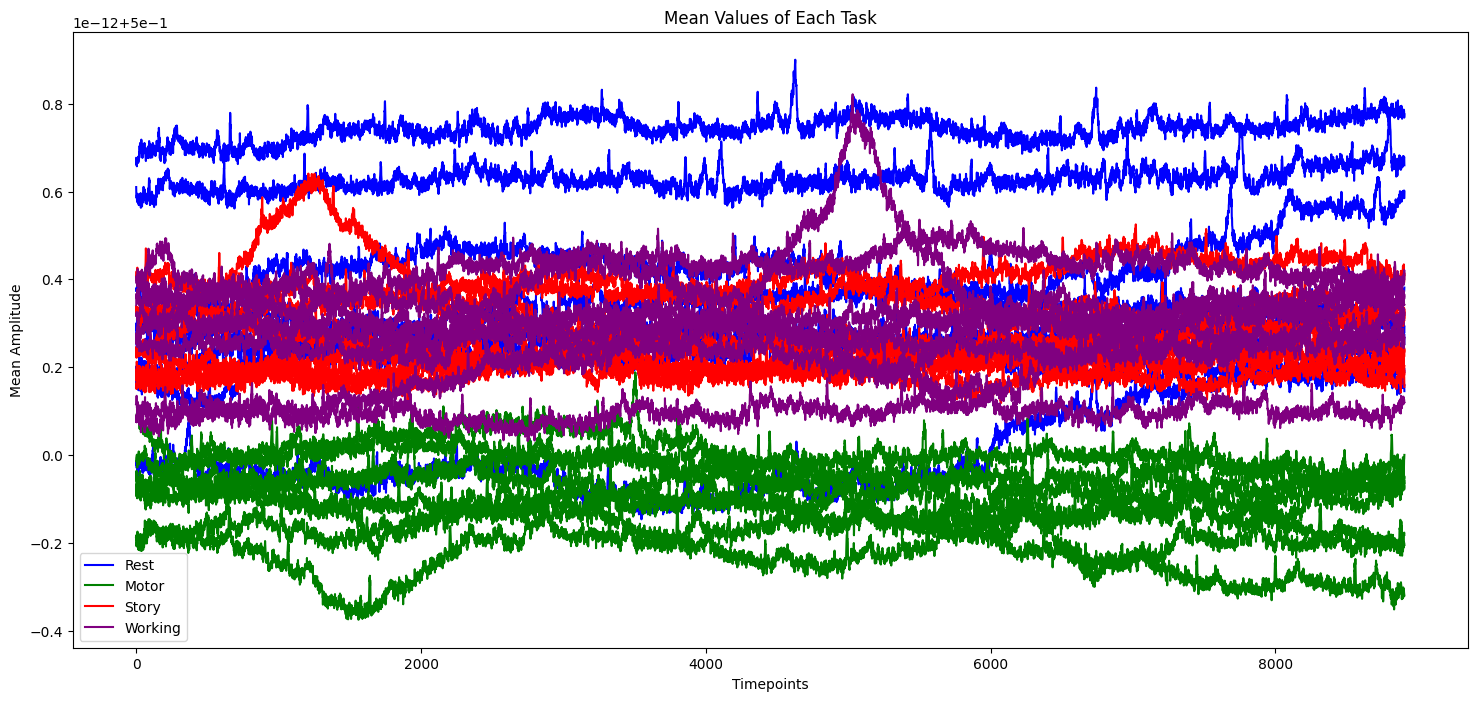

In [ ]:
#############################################################################
############################## SIGMOID SCALING ##############################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_sigmoid = sigmoid_scaling(meg_train_data_array)
array_filtered = apply_lowpass(array_scaled_sigmoid)
del array_scaled_sigmoid
array_doensampled = apply_downsampling(array_filtered)
del array_filtered

# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_doensampled[labels_train_array == 0]
motor_class = array_doensampled[labels_train_array == 1]
story_class = array_doensampled[labels_train_array == 2]
working_class = array_doensampled[labels_train_array == 3]

print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)



# AVERAGE ALL SENSORSOF EACH OBSERVATION

mean_rest_class = np.mean(rest_class, axis=1)
mean_motor_class = np.mean(motor_class, axis=1)
mean_story_class = np.mean(story_class, axis=1)
mean_working_class = np.mean(working_class, axis=1)

del rest_class, motor_class, story_class, working_class


def plot_task_means(mean_arrays, task_labels, colors):
    plt.figure(figsize=(18, 8))

    # Plot an empty line for each task to create the legend
    for label, color in zip(task_labels, colors):
        plt.plot([], [], label=label, color=color)

    # Plot the actual data
    for mean_array, color in zip(mean_arrays, colors):
        for line in mean_array:
            plt.plot(line, color=color, alpha=1)

    plt.title("Mean Values of Each Task")
    plt.xlabel("Timepoints")
    plt.ylabel("Mean Amplitude")
    plt.legend()
    plt.show()

# Example usage remains the same
mean_arrays = [mean_rest_class, mean_motor_class, mean_story_class, mean_working_class]
task_labels = ["Rest", "Motor", "Story", "Working"]
colors = ["blue", "green", "red", "purple"]

plot_task_means(mean_arrays, task_labels, colors)


del mean_rest_class, mean_motor_class, mean_story_class, mean_working_class, mean_arrays, task_labels, colors

In [ ]:
def differential_scaling(data):
    diff_data = np.diff(data, axis=2)
    # Pad the first timepoint to retain original shape
    diff_data = np.pad(diff_data, ((0, 0), (0, 0), (1, 0)), mode='constant', constant_values=0)
    # Apply Min-Max scaling to the differential data
    min_val = np.min(diff_data)
    max_val = np.max(diff_data)
    scaled_data = (diff_data - min_val) / (max_val - min_val)
    return scaled_data


(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)
(8, 248, 8906)


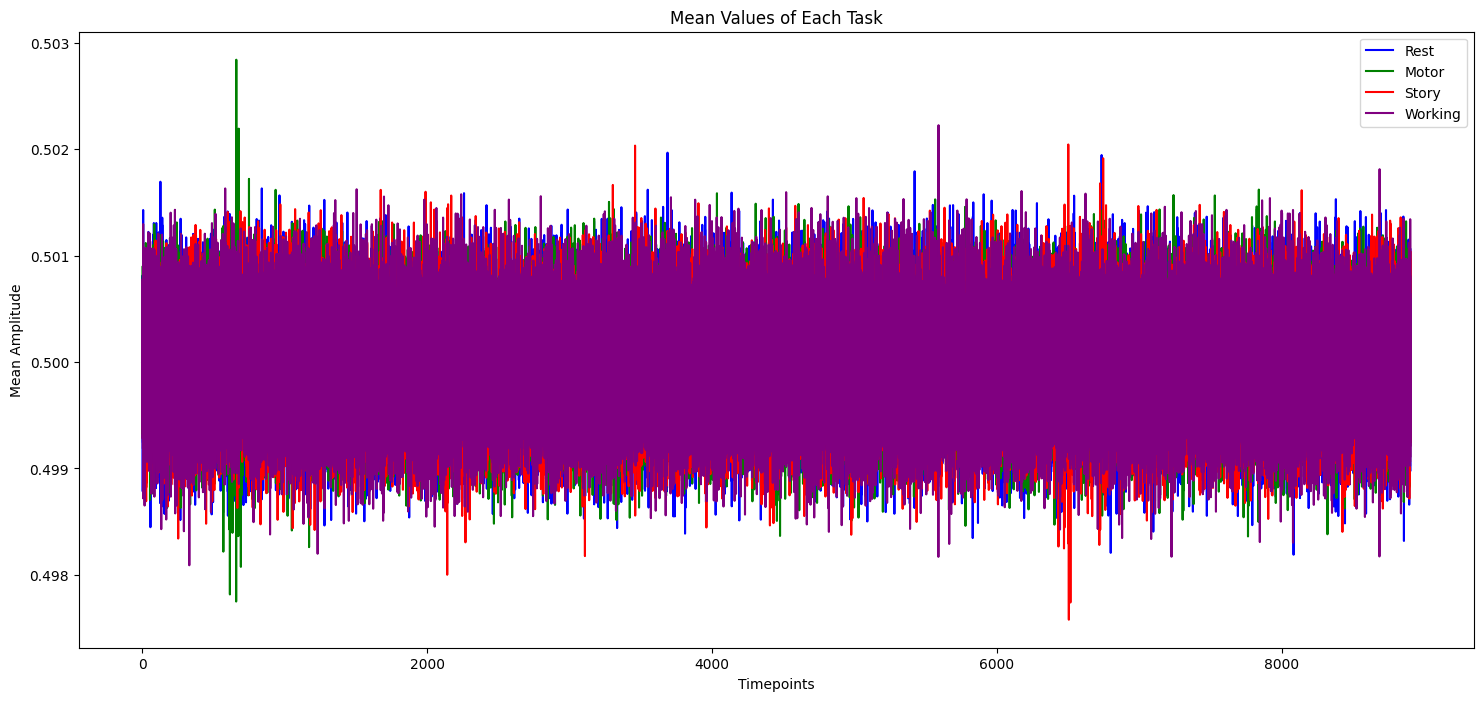

In [ ]:
#############################################################################
########################### DIFFERENTIAL SCALING ############################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_differential = differential_scaling(meg_train_data_array)
array_filtered = apply_lowpass(array_scaled_differential)
del array_scaled_differential
array_doensampled = apply_downsampling(array_filtered)
del array_filtered

# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_doensampled[labels_train_array == 0]
motor_class = array_doensampled[labels_train_array == 1]
story_class = array_doensampled[labels_train_array == 2]
working_class = array_doensampled[labels_train_array == 3]

print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)



# AVERAGE ALL SENSORSOF EACH OBSERVATION

mean_rest_class = np.mean(rest_class, axis=1)
mean_motor_class = np.mean(motor_class, axis=1)
mean_story_class = np.mean(story_class, axis=1)
mean_working_class = np.mean(working_class, axis=1)

del rest_class, motor_class, story_class, working_class


def plot_task_means(mean_arrays, task_labels, colors):
    plt.figure(figsize=(18, 8))

    # Plot an empty line for each task to create the legend
    for label, color in zip(task_labels, colors):
        plt.plot([], [], label=label, color=color)

    # Plot the actual data
    for mean_array, color in zip(mean_arrays, colors):
        for line in mean_array:
            plt.plot(line, color=color, alpha=1)

    plt.title("Mean Values of Each Task")
    plt.xlabel("Timepoints")
    plt.ylabel("Mean Amplitude")
    plt.legend()
    plt.show()

# Example usage remains the same
mean_arrays = [mean_rest_class, mean_motor_class, mean_story_class, mean_working_class]
task_labels = ["Rest", "Motor", "Story", "Working"]
colors = ["blue", "green", "red", "purple"]

plot_task_means(mean_arrays, task_labels, colors)


del mean_rest_class, mean_motor_class, mean_story_class, mean_working_class, mean_arrays, task_labels, colors

In [ ]:
import scipy.signal as signal

def compute_spectrogram(data, fs=2034, nperseg=256):
    frequencies, times, spectrogram = signal.spectrogram(data, fs=fs, nperseg=nperseg, axis=2)
    return spectrogram


(8, 248, 129, 158)
(8, 248, 129, 158)
(8, 248, 129, 158)
(8, 248, 129, 158)


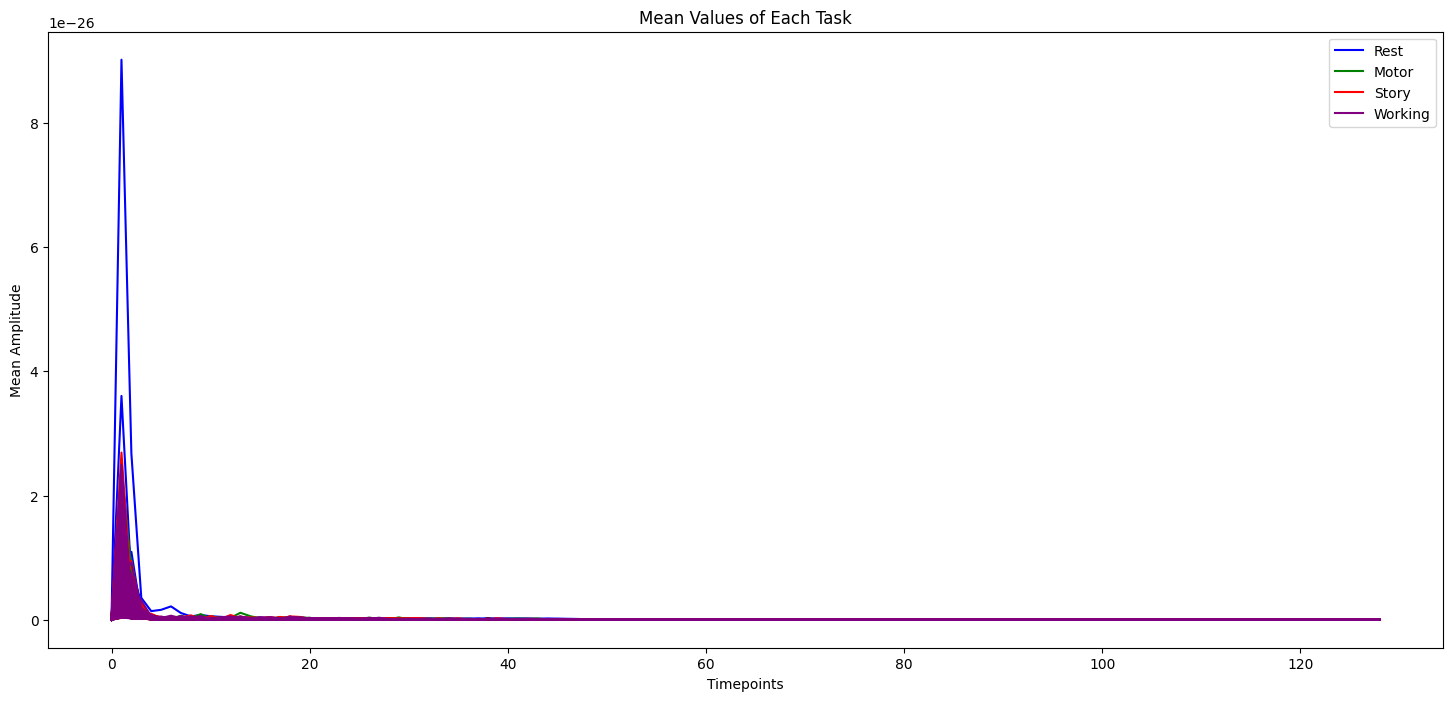

In [ ]:
#############################################################################
########################## TIME FREQUENCY SCALING ###########################
#############################################################################

# APPLY SCALING FILTER AND DOWNSAMPLING
array_scaled_spectogram = compute_spectrogram(meg_train_data_array)
# array_filtered = apply_lowpass(array_scaled_spectogram)
# del array_scaled_spectogram
# array_doensampled = apply_downsampling(array_filtered)
# del array_filtered

# SEPARATE EACH MOTOR TASK IN DIFFERENT ARRAY

rest_class = array_scaled_spectogram[labels_train_array == 0]
motor_class = array_scaled_spectogram[labels_train_array == 1]
story_class = array_scaled_spectogram[labels_train_array == 2]
working_class = array_scaled_spectogram[labels_train_array == 3]

print(rest_class.shape)
print(motor_class.shape)
print(story_class.shape)
print(working_class.shape)



# AVERAGE ALL SENSORSOF EACH OBSERVATION

mean_rest_class = np.mean(rest_class, axis=1)
mean_motor_class = np.mean(motor_class, axis=1)
mean_story_class = np.mean(story_class, axis=1)
mean_working_class = np.mean(working_class, axis=1)

del rest_class, motor_class, story_class, working_class


def plot_task_means(mean_arrays, task_labels, colors):
    plt.figure(figsize=(18, 8))

    # Plot an empty line for each task to create the legend
    for label, color in zip(task_labels, colors):
        plt.plot([], [], label=label, color=color)

    # Plot the actual data
    for mean_array, color in zip(mean_arrays, colors):
        for line in mean_array:
            plt.plot(line, color=color, alpha=1)

    plt.title("Mean Values of Each Task")
    plt.xlabel("Timepoints")
    plt.ylabel("Mean Amplitude")
    plt.legend()
    plt.show()

# Example usage remains the same
mean_arrays = [mean_rest_class, mean_motor_class, mean_story_class, mean_working_class]
task_labels = ["Rest", "Motor", "Story", "Working"]
colors = ["blue", "green", "red", "purple"]

plot_task_means(mean_arrays, task_labels, colors)


del mean_rest_class, mean_motor_class, mean_story_class, mean_working_class, mean_arrays, task_labels, colors